In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

In [183]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)
print(parent_dir)
interpolated_dir = os.path.join(parent_dir, "dataset_interpolated_fixed")
# features = ["game_completed", "relative_strength", "score_difference", "type.id", "home_has_possession", "end.down", "end.yardsToEndzone", "end.distance", "field_position_shift", "home_timeouts_left", "away_timeouts_left"]
features = ["game_completed", "relative_strength", "score_difference", "home_has_possession", "end.down", "end.distance", "end.yardsToEndzone",  "home_timeouts_left", "away_timeouts_left"]
# features = ["relative_strength", "score_difference", "home_has_possession"]

/Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/NFL/ML


In [184]:
# Reset the modules
modules_to_reload = [
    'process_data',
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]

import process_data
training_data = process_data.load_data(interpolated_dir, 
                                       years = [2016, 2017,2018, 2019, 2020, 2021, 2022, 2023], 
                                       history_length = 0, 
                                       features = features, 
                                       label_feature = "home_win")

# validation_data = process_data.load_data(interpolated_dir, 
#                                        years = [2023], 
#                                        history_length = 0, 
#                                        features = features, 
#                                        label_feature = "home_win",
#                                        train = True
#                                        )

test_data = process_data.load_data(interpolated_dir, 
                                       years = [2024],
                                       history_length = 0, 
                                       features = features, 
                                       label_feature = "home_win",
                                       train = False
                                       )


Loading data for 2022
  Processing 271 CSV files in parallel with 8 workers...
  Completed processing 2022
Loading data for 2024
skipping  2024
Loading data for 2023
  Processing 272 CSV files in parallel with 8 workers...
  Completed processing 2022
Loading data for 2024
skipping  2024
Loading data for 2023
  Processing 272 CSV files in parallel with 8 workers...
  Completed processing 2023
Loading data for .DS_Store
Loading data for 2017
  Processing 254 CSV files in parallel with 8 workers...
  Completed processing 2023
Loading data for .DS_Store
Loading data for 2017
  Processing 254 CSV files in parallel with 8 workers...
  Completed processing 2017
Loading data for 2019
  Processing 256 CSV files in parallel with 8 workers...
  Completed processing 2017
Loading data for 2019
  Processing 256 CSV files in parallel with 8 workers...
  Completed processing 2019
Loading data for 2021
  Processing 272 CSV files in parallel with 8 workers...
  Completed processing 2019
Loading data for

In [185]:
# Load edge-case datasets (filter by timestep threshold and score_difference)
# Reload module to pick up the new function
modules_to_reload = [
    'process_data',
]
for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]
import process_data
# edge_featues = ["game_completed", "relative_strength", "score_difference", "home_has_possession", "end.down",  "end.distance", "end.yardsToEndzone", "home_timeouts_left", "away_timeouts_left"]
edge_threshold = 0.95  # minimum timestep to include (adjust as needed)
edge_training_data = process_data.load_edge_case_data(
    interpolated_dir,
    years=[2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
    history_length=0,
    features=features,
    label_feature='home_win',
    threshold=edge_threshold,
    train=True
)
edge_test_data = process_data.load_edge_case_data(
    interpolated_dir,
    years=[2024],
    history_length=0,
    features=features,
    label_feature='home_win',
    threshold=edge_threshold,
    train=False
)

print('Num train entries:', len(edge_training_data))
print('Num test entries:', len(edge_test_data))

Loading data for 2022
  Processing 271 CSV files in parallel with 8 workers...
  Completed processing 2022
Loading data for 2024
skipping  2024
Loading data for 2023
  Processing 272 CSV files in parallel with 8 workers...
  Completed processing 2022
Loading data for 2024
skipping  2024
Loading data for 2023
  Processing 272 CSV files in parallel with 8 workers...
  Completed processing 2023
Loading data for .DS_Store
Loading data for 2017
  Processing 254 CSV files in parallel with 8 workers...
  Completed processing 2023
Loading data for .DS_Store
Loading data for 2017
  Processing 254 CSV files in parallel with 8 workers...
  Completed processing 2017
Loading data for 2019
  Processing 256 CSV files in parallel with 8 workers...
  Completed processing 2017
Loading data for 2019
  Processing 256 CSV files in parallel with 8 workers...
  Completed processing 2019
Loading data for 2021
  Processing 272 CSV files in parallel with 8 workers...
  Completed processing 2019
Loading data for

In [241]:
# Train a single LogisticRegressionModel on one timestep from the edge-case data
modules_to_reload = [
    'models.logistic_regression',
    'models.Model'
]
for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]
from models.logistic_regression import LogisticRegressionModel
from models.xg_boost import LightGBM
from sklearn.model_selection import train_test_split

# Define numeric/other features here so this cell is self-contained
edge_numeric_features = ["score_difference", "relative_strength", "end.yardsToEndzone", "end.distance"]
edge_other_features = ["home_has_possession", "end.down", "home_timeouts_left", "away_timeouts_left"]

# Choose timestep to train on (by default the largest available)
if not edge_training_data:
    raise ValueError("edge_training_data is empty")

# Prepare training data for selected timestep
X = np.array([entry["rows"].reshape(-1) for entry in edge_training_data])
y = np.array([entry["label"] for entry in edge_training_data])

# Instantiate and train the model
single_model = LogisticRegressionModel(
    numeric_features=edge_numeric_features,
    other_features=edge_other_features,
    all_features=features,
    use_calibration=False,
    optimize_hyperparams=False
)

xgboost_model = LightGBM(
    numeric_features=edge_numeric_features,
    other_features=edge_other_features,
    all_features=features,
    use_calibration=False,
    optimize_hyperparams=False 
)


single_model.fit(X, y)
# Keep model in notebook namespace
edge_single_model = xgboost_model

: Training Loss = 0.4672, Accuracy = 0.7885, Test Loss = 0.4579, Test Accuracy = 0.7900


In [257]:
# Train a single DirectClassifier (neural network) on one timestep from the edge-case data
modules_to_reload = [
    'models.direct_prediction_network',
    'models.Model'
]
for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]

from models.direct_prediction_network import DirectPredictionNetwork, DirectClassifier
import torch
from torch import nn
from sklearn.model_selection import train_test_split

# Choose timestep to train on (by default the largest available)
if not edge_training_data:
    raise ValueError("edge_training_data is empty")

# Prepare training data (flatten rows to 2D)
X = np.array([np.asarray(entry['rows']).reshape(-1) for entry in edge_training_data], dtype=np.float32)
y = np.array([entry['label'] for entry in edge_training_data], dtype=np.float32)

# Train/validation split
if len(X) < 10:
    print(f"Too few samples ({len(X)}) - using all for training")
    X_train, y_train, X_val, y_val = X, y, None, None
else:
    unique, counts = np.unique(y, return_counts=True)
    stratify = y if (len(unique) > 1 and counts.min() >= 2) else None
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=42, stratify=stratify)

print(f"Prepared X_train shape: {X_train.shape}, X_val shape: {None if X_val is None else X_val.shape}")

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Build network
input_dim = X.shape[1]
direct_net = DirectPredictionNetwork(input_dim=input_dim, hidden_dims=[64, 32, 16, 8], dropout_rate=0.4, num_layers=4).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(direct_net.parameters(), lr=1e-3, weight_decay=1e-4)

# Instantiate classifier
direct_classifier = DirectClassifier(
    model=direct_net,
    epochs=50,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    features=features,  # uses same feature ordering as the dataset
    scheduler=None,
    use_scaler=True,
    optimize_hyperparams=False
)

# Train (classifier handles internal scaling and uses provided val set)
direct_classifier.fit(X_train, y_train, val_X=X_val, val_y=y_val, batch_size=64, verbose=True)

print("Direct classifier training finished.")
print("Train loss:", direct_classifier.final_train_loss)
print("Train accuracy:", direct_classifier.final_train_accuracy)
print("Val loss:", direct_classifier.final_val_loss)
print("Val accuracy:", direct_classifier.final_val_accuracy)

# Keep classifier in notebook namespace
edge_direct_classifier = direct_classifier

Prepared X_train shape: (16513, 9), X_val shape: (1835, 9)
Starting training on device: cpu
Early stopping at epoch 49
Best epoch: 39, Train Acc: 0.8169, Train Loss: 0.4120, Val Acc: 0.8251, Val Loss: 0.3721
Restored model from best epoch 39 with val_loss: 0.372066
Direct classifier training finished.
Train loss: 0.4120402308504554
Train accuracy: 0.8168715557439593
Val loss: 0.3720663174473006
Val accuracy: 0.8250681198910081
Early stopping at epoch 49
Best epoch: 39, Train Acc: 0.8169, Train Loss: 0.4120, Val Acc: 0.8251, Val Loss: 0.3721
Restored model from best epoch 39 with val_loss: 0.372066
Direct classifier training finished.
Train loss: 0.4120402308504554
Train accuracy: 0.8168715557439593
Val loss: 0.3720663174473006
Val accuracy: 0.8250681198910081


In [333]:
# other_features = [
#             "type.id",             # Play type (categorical)
#             "home_has_possession", # Binary indicator
#             "end.down",            # Down number (1-4, discrete)
#             "home_timeouts_left",  # Discrete count (0-3)
#             "away_timeouts_left",  # Discrete count (0-3)
#             "game_completed"
#         ]
# numeric_features = [
#     "score_difference",
#     "relative_strength", 
#     "end.yardsToEndzone", 
#     "end.distance", 
#     "field_position_shift"
# ]
other_features = [
            "home_has_possession", # Binary indicator
            # "end.down",            # Down number (1-4, discrete)
            # "home_timeouts_left",  # Discrete count (0-3)
            # "away_timeouts_left",  # Discrete count (0-3)
        ]
numeric_features = [
    "score_difference",
    "relative_strength", 
    # "end.yardsToEndzone", 
    # "end.distance", 
]

In [334]:
class CombinedModel:
    def __init__(self, model, alt_model, features):
        self.model = model
        self.alt_model = alt_model
        self.index = features.index("score_difference")
    def predict_proba(self, X):
        result = []
        for entry in X:
            if abs(entry[self.index]) <= 7:
                result.append(self.alt_model.predict_proba(np.array([entry]))[0])
            else:
                result.append(self.model.predict_proba(np.array([entry]))[0])
        return np.array(result)
    def score(self, X, y):
        predictions = self.predict_proba(X)[:, 1]  # Get probabilities for the positive class
        return np.mean((predictions >= 0.5) == y)  # Calculate accuracy

In [335]:
# Setup model for each timestep
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
# create an array of logistic regression models

modules_to_reload = [
    'models.logistic_regression',
    'models.Model'
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]
from models.Model import Model
from models.logistic_regression import setup_logistic_regression_models

models = setup_logistic_regression_models(training_data, None, numeric_features, other_features, features, optimize_hyperparams=False, use_calibration=False)


Processing timestep: 0.0
Timestep 0.00% : Training Loss = 0.6248, Accuracy = 0.6511, Test Loss = 0.6356, Test Accuracy = 0.6449
Processing timestep: 0.005
Timestep 0.50% : Training Loss = 0.6320, Accuracy = 0.6422, Test Loss = 0.6394, Test Accuracy = 0.6263
Processing timestep: 0.01
Timestep 1.00% : Training Loss = 0.6206, Accuracy = 0.6447, Test Loss = 0.6310, Test Accuracy = 0.6273
Processing timestep: 0.015
Timestep 1.50% : Training Loss = 0.6351, Accuracy = 0.6318, Test Loss = 0.6211, Test Accuracy = 0.6561
Processing timestep: 0.02
Timestep 2.00% : Training Loss = 0.6343, Accuracy = 0.6365, Test Loss = 0.6454, Test Accuracy = 0.6069
Processing timestep: 0.025
Timestep 2.50% : Training Loss = 0.6323, Accuracy = 0.6365, Test Loss = 0.6369, Test Accuracy = 0.6482
Processing timestep: 0.03
Timestep 3.00% : Training Loss = 0.6320, Accuracy = 0.6422, Test Loss = 0.6394, Test Accuracy = 0.6263
Processing timestep: 0.01
Timestep 1.00% : Training Loss = 0.6206, Accuracy = 0.6447, Test Loss

In [336]:
modules_to_reload = [
    'process_data',
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]
import process_data

new_models = process_data.replace_model(models, single_model, CombinedModel, features, 0.95)

In [337]:
print(models[0.99])
print(new_models[1])

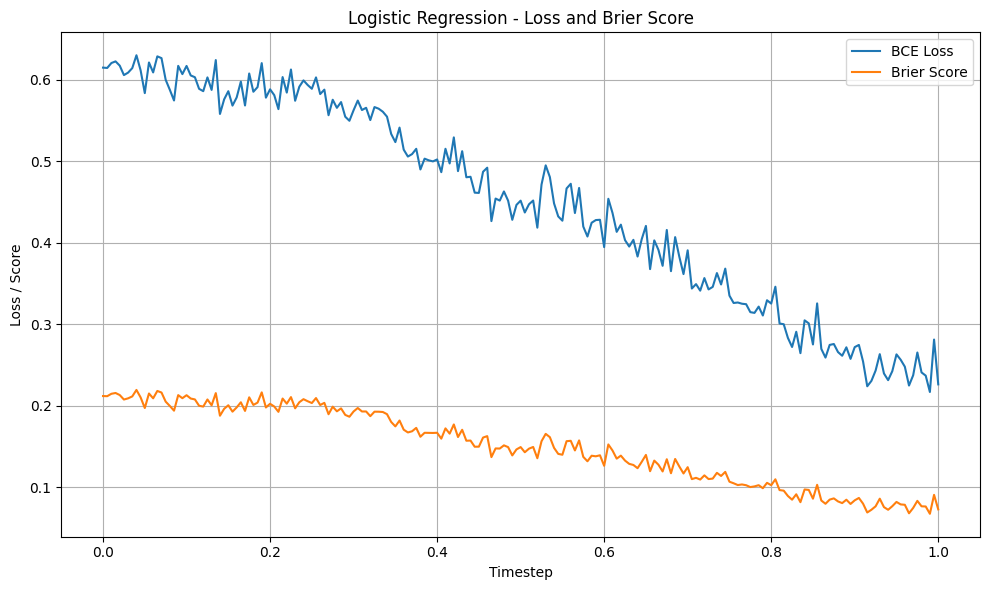

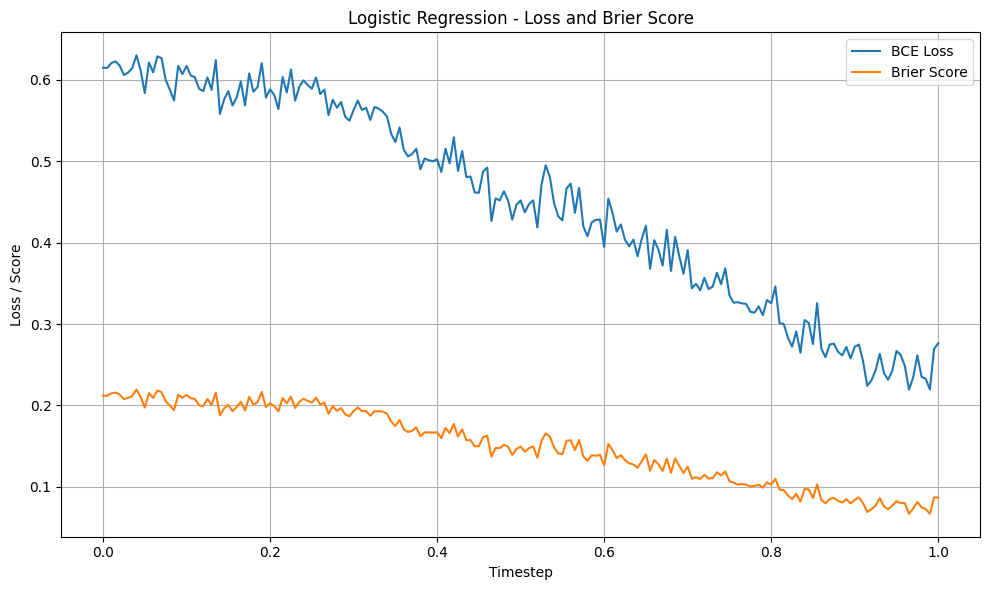

{'timesteps': [0.0,
  0.005,
  0.01,
  0.015,
  0.02,
  0.025,
  0.03,
  0.035,
  0.04,
  0.045,
  0.05,
  0.055,
  0.06,
  0.065,
  0.07,
  0.075,
  0.08,
  0.085,
  0.09,
  0.095,
  0.1,
  0.105,
  0.11,
  0.115,
  0.12,
  0.125,
  0.13,
  0.135,
  0.14,
  0.145,
  0.15,
  0.155,
  0.16,
  0.165,
  0.17,
  0.175,
  0.18,
  0.185,
  0.19,
  0.195,
  0.2,
  0.205,
  0.21,
  0.215,
  0.22,
  0.225,
  0.23,
  0.235,
  0.24,
  0.245,
  0.25,
  0.255,
  0.26,
  0.265,
  0.27,
  0.275,
  0.28,
  0.285,
  0.29,
  0.295,
  0.3,
  0.305,
  0.31,
  0.315,
  0.32,
  0.325,
  0.33,
  0.335,
  0.34,
  0.345,
  0.35,
  0.355,
  0.36,
  0.365,
  0.37,
  0.375,
  0.38,
  0.385,
  0.39,
  0.395,
  0.4,
  0.405,
  0.41,
  0.415,
  0.42,
  0.425,
  0.43,
  0.435,
  0.44,
  0.445,
  0.45,
  0.455,
  0.46,
  0.465,
  0.47,
  0.475,
  0.48,
  0.485,
  0.49,
  0.495,
  0.5,
  0.505,
  0.51,
  0.515,
  0.52,
  0.525,
  0.53,
  0.535,
  0.54,
  0.545,
  0.55,
  0.555,
  0.56,
  0.565,
  0.57,
  0.575,
  0.58,

In [338]:
# # Test accuracy of model for each timestep on test data and plot
# accuracies = []
# timesteps = []
import process_data
modules_to_reload = [
    'process_data',
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]

x = process_data.plot_loss(models, test_data, "Logistic Regression")
# process_data.plot_accuracy(models, test_data, "Logistic Regression")
process_data.plot_loss(new_models, test_data, "Logistic Regression")

In [343]:
model = new_models[0.99]
# features = ["relative_strength", "score_difference", "home_has_possession", "end.down", "end.distance", "end.yardsToEndzone",  "home_timeouts_left", "away_timeouts_left"]
data_point = [0.99, 0.5, -4, 1, 1, 1, 1, 1, 1]
model.predict_proba(np.array([data_point]))

array([[0.73350332, 0.26649668]])

In [156]:
# Save the model
import pickle
filename = 'logistic_regression_model.pickle'
pickle.dump(models, open(filename, 'wb'))

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
%reload_ext autoreload
from models.utils import SHAP_analysis
# model = models[0.99]
# # Health Check:
# if hasattr(model.model, "coef_"):
#     feature_names = model.all_features if hasattr(model, "all_features") else None
#     coefs = model.model.coef_[0]  # shape (n_features,)
#     if feature_names is not None and len(feature_names) == len(coefs):
#         for name, coef in zip(feature_names, coefs):
#             print(f"{name}: {coef}")

SHAP_analysis(models, training_data, test_data, "logistic_regression", "shap_values/LR", num_threads = 1)
# x = np.array([[0.1, 0.9, 20, 1, 0, 1, 50, 20, 2, 2, 2]])
# model.predict_proba(x)


In [349]:
modules_to_reload = [
    "process_data"
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]
import process_data
features = ["game_completed", "relative_strength", "score_difference", "home_has_possession", "end.down", "end.distance", "end.yardsToEndzone",  "home_timeouts_left", "away_timeouts_left"]
process_data.assess_differences(models, test_data, 0.995, features, threshold=0, alt_model=edge_direct_classifier)

491
-0.01912081357472113
-0.022492095767675364
     game_completed  relative_strength  score_difference  home_has_possession  end.down  end.distance  end.yardsToEndzone  home_timeouts_left  away_timeouts_left  label     predicted  alt_predicted    ESPN          diff
0          0.993611             0.4073              -5.0                  1.0       3.0           1.0                86.0                 1.0                 2.0    1.0  1.107088e-01   5.312421e-02  0.7133 -7.086419e-01
1          0.992500             0.4073              -5.0                  1.0       3.0           1.0                14.0                 1.0                 2.0    1.0  1.107088e-01   2.733898e-01  0.7083 -7.057499e-01
2          0.993056             0.2880              -5.0                  1.0       4.0           1.0                 1.0                 2.0                 0.0    1.0  9.572631e-02   1.099813e-01  0.6018 -6.591477e-01
3          0.993611             0.4073              -5.0                 

In [346]:
from process_data import write_predictions
write_predictions(new_models, interpolated_dir, [2024], 0, features, replace_nan_val = 0, phat_b = "LR_phat_b")

Loading data for 2024
Processed file:  game_401671629.csv
Processed file:  game_401671601.csv
Processed file:  game_401671826.csv
Processed file:  game_401671601.csv
Processed file:  game_401671826.csv
Processed file:  game_401671832.csv
Processed file:  game_401671749.csv
Processed file:  game_401671832.csv
Processed file:  game_401671749.csv
Processed file:  game_401671775.csv
Processed file:  game_401671761.csv
Processed file:  game_401671775.csv
Processed file:  game_401671761.csv
Processed file:  game_401671760.csv
Processed file:  game_401671774.csv
Processed file:  game_401671760.csv
Processed file:  game_401671774.csv
Processed file:  game_401671748.csv
Processed file:  game_401671833.csv
Processed file:  game_401671748.csv
Processed file:  game_401671833.csv
Processed file:  game_401671827.csv
Processed file:  game_401671600.csv
Processed file:  game_401671827.csv
Processed file:  game_401671600.csv
Processed file:  game_401671628.csv
Processed file:  game_401671616.csv
Proces

In [347]:

import os
import shutil

# Define the ancestor directory and the parent directory
src_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Adjust the number of "../" as needed
dest_dir = os.path.abspath(os.path.join(os.getcwd(), "../../"))

# Specify the file or directory to copy from the ancestor directory
source = os.path.join(src_dir, "dataset_interpolated_fixed", "2024")  # Replace with the actual name
destination = os.path.join(dest_dir, "test_7", "LR_end")  # Replace with the desired name

# Perform the copy operation
if os.path.exists(source):
    if os.path.isdir(source):
        shutil.copytree(source, destination)
    else:
        shutil.copy2(source, destination)
    print(f"Copied '{source}' to '{destination}'")
else:
    print(f"Source '{source}' does not exist")

Copied '/Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/NFL/ML/dataset_interpolated_fixed/2024' to '/Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/NFL/test_7/LR_end'
